In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold, KFold
import os
from model import MNISTClassifier, COLOR_LIST
import matplotlib.pyplot as plt


## Parameters

In [13]:
#Parameters for CNN
num_epochs=7
batch_size=128
#Parameters for KFold Cross validation
K=3


## Importing our Model: CNN with Mini-Batch Gradient Descent

In [14]:
model = MNISTClassifier(num_epochs=num_epochs,batch_size=batch_size)
print(model)

MNISTClassifier(
  (criterion): CrossEntropyLoss()
  (layer_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (fc_1): Linear(in_features=1568, out_features=1000, bias=True)
  (fc_2): Linear(in_features=1000, out_features=10, bias=True)
)


In [15]:
mnist_train, mnist_test = model.prepare_data()
test_data=model.test_dataloader(mnist_test)

### Data Visualization

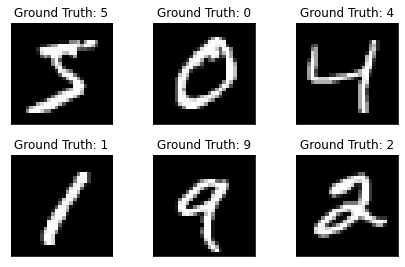

In [16]:
examples = enumerate(model.train_dataloader(mnist_train))
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### Training with KFold Cross Validation

In [17]:
KF_splits = KFold(n_splits= K, shuffle = True, random_state = 42)


Crossvalidation fold: 1/3
Epoch [1/7], Step [100/313], Loss: 0.3558
Epoch [1/7], Step [200/313], Loss: 0.2156
Epoch [1/7], Step [300/313], Loss: 0.3232
Epoch [2/7], Step [100/313], Loss: 0.1288
Epoch [2/7], Step [200/313], Loss: 0.2369
Epoch [2/7], Step [300/313], Loss: 0.0654
Epoch [3/7], Step [100/313], Loss: 0.0811
Epoch [3/7], Step [200/313], Loss: 0.1219
Epoch [3/7], Step [300/313], Loss: 0.1404
Epoch [4/7], Step [100/313], Loss: 0.0633
Epoch [4/7], Step [200/313], Loss: 0.0924
Epoch [4/7], Step [300/313], Loss: 0.1361
Epoch [5/7], Step [100/313], Loss: 0.0793
Epoch [5/7], Step [200/313], Loss: 0.1321
Epoch [5/7], Step [300/313], Loss: 0.0138
Epoch [6/7], Step [100/313], Loss: 0.1146
Epoch [6/7], Step [200/313], Loss: 0.1857
Epoch [6/7], Step [300/313], Loss: 0.2066
Epoch [7/7], Step [100/313], Loss: 0.1278
Epoch [7/7], Step [200/313], Loss: 0.1120
Epoch [7/7], Step [300/313], Loss: 0.1365

Best loss: 0.009532570838928223


Crossvalidation fold: 2/3
Epoch [1/7], Step [100/313], L

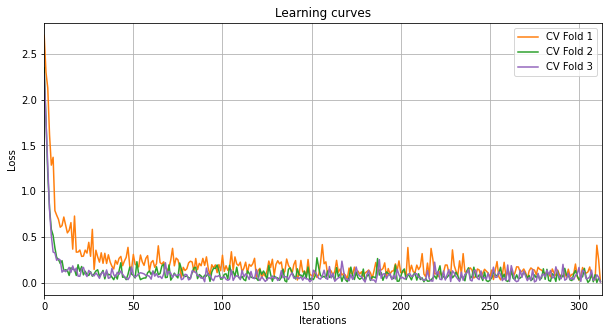

In [18]:
models=[]
losses=[]
fig, ax = plt.subplots(1,1, figsize=(10,5))
best_loss=1e2
for (k,(train_idx, valid_idx)) in enumerate(KF_splits.split(mnist_train)):
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))  
    #Sample Train and Validation data
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_data=model.train_dataloader(mnist_train,sampler=train_sampler)
    val_data=model.test_dataloader(mnist_train,sampler=valid_sampler)
    #Compute Traning and get best_model, loss and learning curve across epochs
    best_model, best_final_loss, best_learning_curve =model.compute_training(train_data)
    #Plot best learning curve
    model.plot_learning_curve(best_learning_curve,
                                    ax=ax,
                                    label='CV Fold {}'.format(k+1),
                                    color=COLOR_LIST[k])
    print('\nBest loss: {}\n'.format(best_final_loss))
    if best_final_loss < best_loss:
        torch.save(best_model, 'best_model.pt')
        best_loss=best_final_loss

plt.legend()
plt.grid()
plt.show()

## Evaluation

In [19]:
best_model_params = torch.load('best_model.pt')

test_loss=model.compute_validation(test_data)
model.load_state_dict(best_model_params)
model.eval()
test_loss=model.compute_validation(test_data)
print('Test loss: ', test_loss)

Test loss:  0.04726054146885872
